<a href="https://colab.research.google.com/github/adityaharshsingh7/ml/blob/main/machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# Display basic info and check for missing values
print(data.head())
print(data.describe())
print(data.isnull().sum())

# Drop columns with excessive missing values or irrelevant info
data = data.drop(columns=['holiday'])  # 'holiday' column is mostly NaN

# Convert 'date_time' to datetime and extract useful time features
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour
data['weekday'] = data['date_time'].dt.weekday
data['month'] = data['date_time'].dt.month

In [ ]:
# Basic visualization
plt.figure(figsize=(14, 8))
plt.plot(data['date_time'], data['traffic_volume'], color='blue')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Traffic Volume')
plt.show()

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['weather_main'], drop_first=True)

# Drop columns not needed for modeling
data = data.drop(columns=['weather_description', 'date_time'])

# Separate features and target
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection (optional but improves performance)
selector = SelectKBest(score_func=f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Define models and parameter grid
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Machine': SVR()
}



In [3]:
# Hyperparameter Tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_selected, y_train)
best_rf_model = grid_search.best_estimator_

# Ensemble model
ensemble_model = VotingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', best_rf_model),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('svr', SVR())
    ]
)
ensemble_model.fit(X_train_selected, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_leaf=2,
                                                   n_estimators=150,
                                                   random_state=42)),
                            ('gb', GradientBoostingRegressor(random_state=42)),
                            ('svr', SVR())])

In [4]:
# Final set of models to evaluate
final_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': best_rf_model,
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'Ensemble': ensemble_model
}

results = {}

for name, model in final_models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R-squared': r2}
    print(f"Model: {name}")
    print(f"  MSE: {mse:.2f}")
    print(f"  R^2: {r2:.4f}\n")


Model: Linear Regression
  MSE: 3281957.45
  R^2: 0.1699

Model: Random Forest
  MSE: 202212.73
  R^2: 0.9489

Model: Gradient Boosting
  MSE: 316270.13
  R^2: 0.9200

Model: Support Vector Machine
  MSE: 3345322.50
  R^2: 0.1538

Model: Ensemble
  MSE: 1016411.62
  R^2: 0.7429



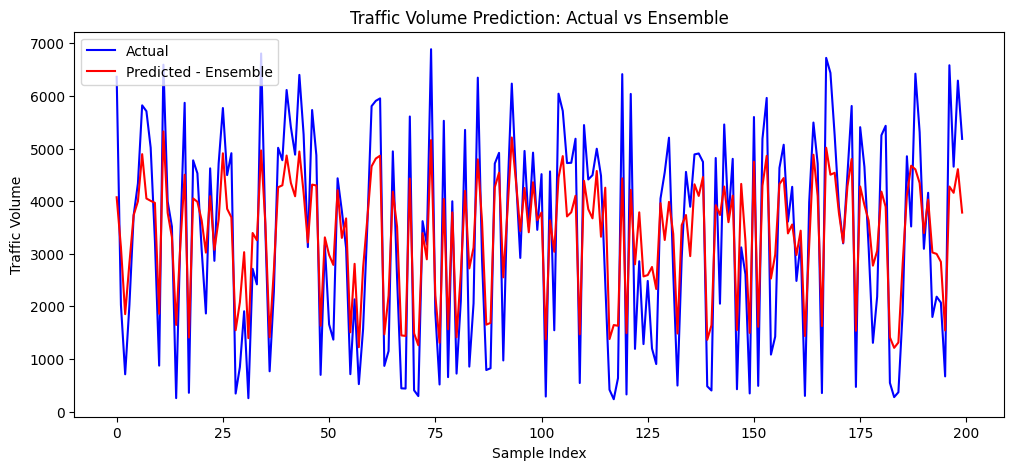

In [5]:
# Enhanced, clearer visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label='Actual', color='blue')
plt.plot(list(final_models['Ensemble'].predict(X_test_selected))[:200], label='Predicted - Ensemble', color='red')
plt.title('Traffic Volume Prediction: Actual vs Ensemble')
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()